In [132]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import pickle

In [133]:
def loadData(pickleName):
    # Open specific pickle file used
    file = open(pickleName, 'rb')    
    
    train_img_paths = pickle.load(file)
    train_labels = pickle.load(file)
    validation_img_paths = pickle.load(file)
    validation_labels = pickle.load(file)
    test_img_paths = pickle.load(file)
    test_labels = pickle.load(file)
    characters = pickle.load(file)
    max_len = pickle.load(file)
    
    file.close()
    
    return train_img_paths, train_labels, validation_img_paths, validation_labels, test_img_paths, test_labels, characters, max_len

In [134]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [135]:
# Load prepared dataset
dataset_name = "iam_dataset.pickle"
train_img_paths, train_labels, validation_img_paths, validation_labels, test_img_paths, test_labels, characters, max_len = loadData(dataset_name)

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [136]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32
AUTOTUNE = tf.data.AUTOTUNE


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)   # reads image out of the specified path
    image = tf.image.decode_png(image, 1) # converts png format into uint8/16 tensor
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 # Converts into float and makes all pixels range from 0 to 1
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) # Do all the character to number mappings and return as ints
    length = tf.shape(label)[0] # Know the size of the word
    # pad 0 at the end to match the size of the largest word in the training dataset
    pad_amount = max_len - length 
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [137]:
train_ds = prepare_dataset(train_img_paths, train_labels)
validation_ds = prepare_dataset(validation_img_paths, validation_labels)
test_ds = prepare_dataset(test_img_paths, test_labels)

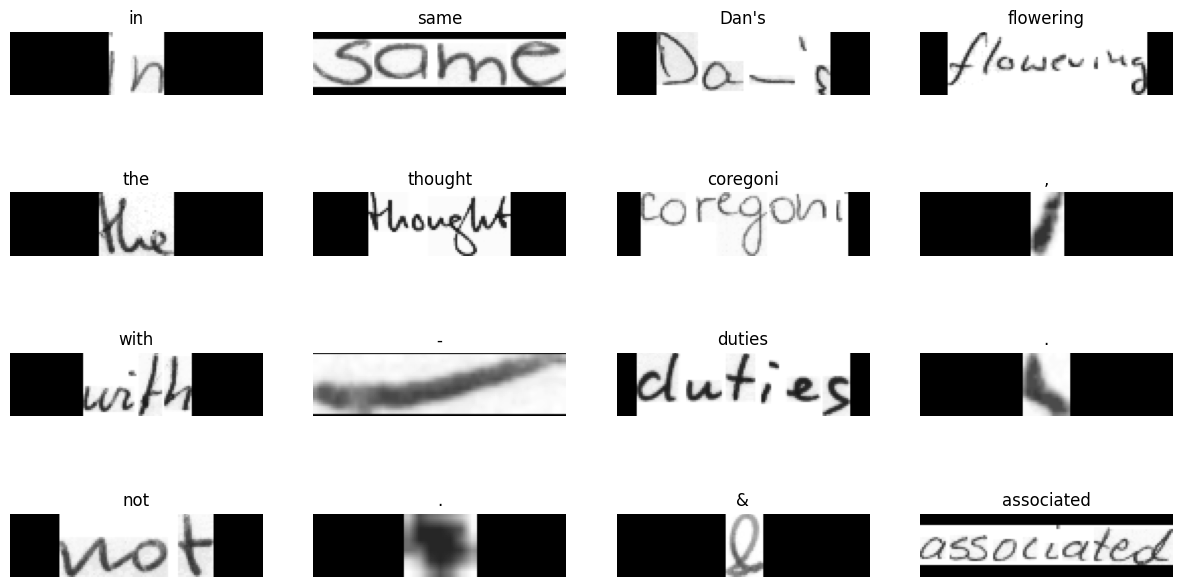

In [138]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [139]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [140]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [141]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print( f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")

In [142]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Epoch 1/10
2/2 [==============================] - 1s 33ms/step
Mean edit distance for epoch 1: 20.5030
1206/1206 [==============================] - 517s 423ms/step - loss: 13.7777 - val_loss: 11.9542
Epoch 2/10
2/2 [==============================] - 0s 29ms/step
Mean edit distance for epoch 2: 20.1051
1206/1206 [==============================] - 386s 320ms/step - loss: 10.9478 - val_loss: 9.5219
Epoch 3/10
2/2 [==============================] - 0s 27ms/step
Mean edit distance for epoch 3: 19.5982
1206/1206 [==============================] - 361s 299ms/step - loss: 8.8317 - val_loss: 7.3239
Epoch 4/10
2/2 [==============================] - 0s 30ms/step
Mean edit distance for epoch 4: 18.6814
1206/1206 [==============================] - 366s 304ms/step - loss: 6.9046 - val_loss: 5.3904
Epoch 5/10
2/2 [==============================] - 0s 28ms/step
Mean edit distance for epoch 5: 18.3019
1206/1206 [==============================] - 373s 309ms/step - loss: 5.4977 - val_loss: 4.3772
Epoch 6

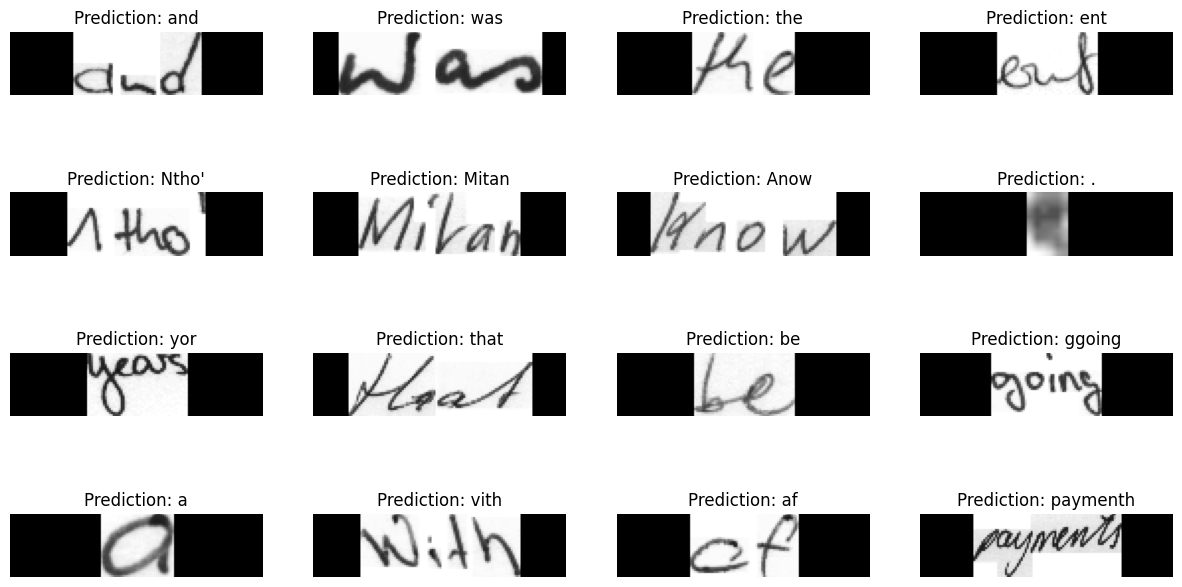

Epoch 1/20
2/2 [==============================] - 1s 26ms/step
Mean edit distance for epoch 1: 20.4762
1206/1206 [==============================] - 350s 285ms/step - loss: 13.7437 - val_loss: 11.9437
Epoch 2/20
2/2 [==============================] - 0s 27ms/step
Mean edit distance for epoch 2: 20.1587
1206/1206 [==============================] - 439s 364ms/step - loss: 10.9657 - val_loss: 9.7823
Epoch 3/20
2/2 [==============================] - 0s 30ms/step
Mean edit distance for epoch 3: 19.8182
1206/1206 [==============================] - 353s 292ms/step - loss: 9.1796 - val_loss: 8.0699
Epoch 4/20
2/2 [==============================] - 0s 32ms/step
Mean edit distance for epoch 4: 19.1625
1206/1206 [==============================] - 370s 307ms/step - loss: 7.7212 - val_loss: 6.4188
Epoch 5/20
2/2 [==============================] - 0s 37ms/step
Mean edit distance for epoch 5: 18.6007
1206/1206 [==============================] - 379s 315ms/step - loss: 6.3606 - val_loss: 5.1061
Epoch 6

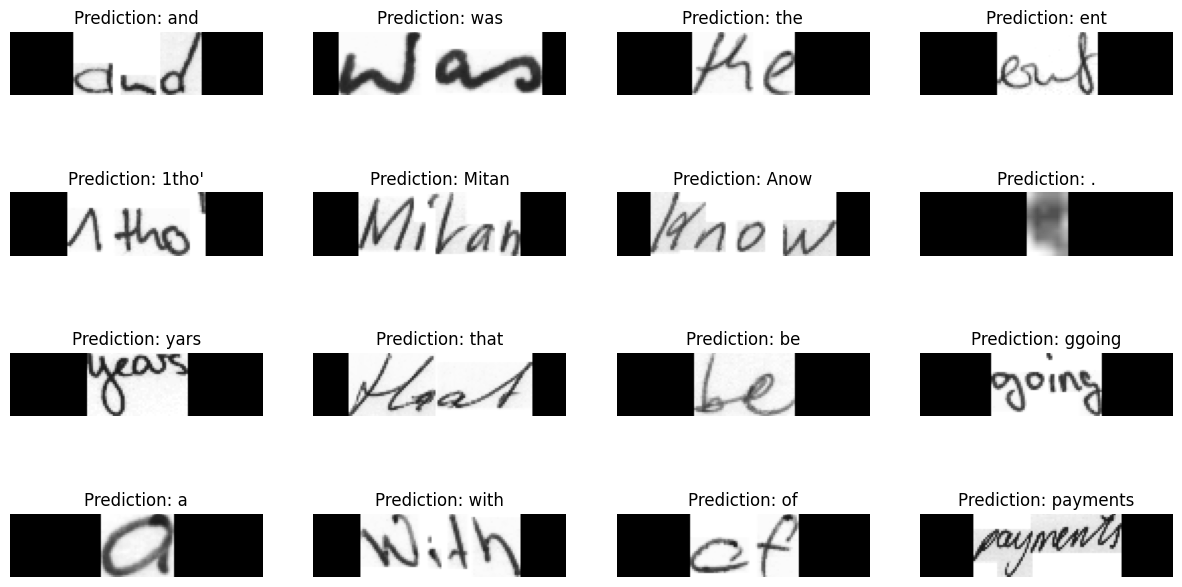

Epoch 1/30
2/2 [==============================] - 2s 43ms/step
Mean edit distance for epoch 1: 20.4054
1206/1206 [==============================] - 1986s 2s/step - loss: 13.7710 - val_loss: 11.8740
Epoch 2/30
2/2 [==============================] - 0s 60ms/step
Mean edit distance for epoch 2: 20.1139
1206/1206 [==============================] - 770s 639ms/step - loss: 10.9643 - val_loss: 9.7150
Epoch 3/30
2/2 [==============================] - 0s 50ms/step
Mean edit distance for epoch 3: 19.8587
1206/1206 [==============================] - 783s 649ms/step - loss: 9.3869 - val_loss: 8.2471
Epoch 4/30
 204/1206 [====>.........................] - ETA: 10:13 - loss: 8.5146

In [ ]:
for i in range(10, 101,10):
    epochs = i  # To get good results this should be at least 50.
    
    model = build_model()
    prediction_model = keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )
    edit_distance_callback = EditDistanceCallback(prediction_model)
    
    # Train the model.
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        callbacks=[edit_distance_callback],
    )

    #  Let's check results on some test samples.
    for batch in test_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(15, 8))
    
        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)
    
        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]
    
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    
    plt.show()